In [3]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np
!pip install folium
import folium

     |████████████████████████████████| 93 kB 1.5 MB/s eta 0:00:011


In [6]:
import pandas as pd
import numpy as np
import requests
#from bs4 import BeautifulSoup
import os
#!conda install -c conda-forge folium=0.5.0 --yes
import folium 
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
import seaborn as sns

print('Done!')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.2
  latest version: 4.8.3

Please update conda by running

    $ conda update -n base conda



## Package Plan ##

  environment location: /srv/conda/envs/notebook

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          97 KB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0-pyh9f0ad1d_0



geopy-2.0.0          | 63 KB     | ##################################### | 100% 
ge

In [20]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

CLIENT_ID = 'KUKHGXJ2T4SKDTZURMZ2CBRETYGSKKQSEXNXHXBXWOW2DZB2' # your Foursquare ID
CLIENT_SECRET = 'RMCTUXYWHLWYNQ1ZQYLAUHX2KM2ELUUZEIC3Q5N5X0Z0LJVJ' # your Foursquare Secret
LIMIT = 40
VERSION = '20200719'
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

Your credentails:
CLIENT_ID: KUKHGXJ2T4SKDTZURMZ2CBRETYGSKKQSEXNXHXBXWOW2DZB2
CLIENT_SECRET:RMCTUXYWHLWYNQ1ZQYLAUHX2KM2ELUUZEIC3Q5N5X0Z0LJVJ


Now lets use the above codes to get our initial NYC data

In [16]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [17]:
ny_data.shape

(306, 4)

Now that we have our initial data, lets start analyzing it. We can see below that Manhattan has the least number of neighborhoods in all five boroughs

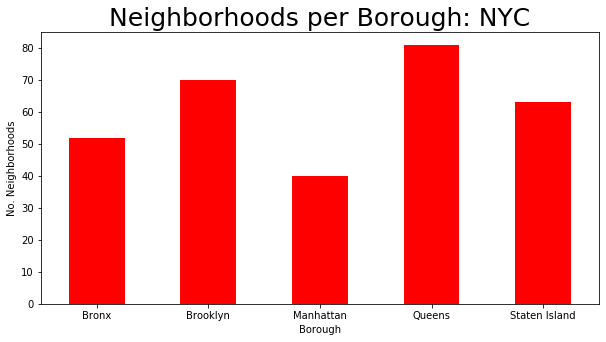

In [18]:
clr = 'r'
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 25)
plt.xlabel('Borough', fontsize = 10)
plt.ylabel('No. Neighborhoods',fontsize = 10)
plt.xticks(rotation = 'horizontal')
plt.show()

We can see that Queens borough has the most number of neighborhoods. Let us now prepare neighborhood lst that contains Japanese restaurants

Lets analyze how many Japanese restaurants are present in each neighborhood and burough and plot the results

In [21]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
Japanese_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    Japanese_resturants=venues[venues['Category']=='Japanese Restaurant']   
    print('(',count,'/',len(ny_data),')','Japanese Resturants in '+Neighborhood+', '+Borough+':'+str(len(Japanese_resturants)))
    print(row)
    for resturant_detail in Japanese_resturants.values.tolist():
        id, name , category=resturant_detail
        Japanese_rest_ny = Japanese_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Japanese Resturants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Japanese Resturants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Japanese Resturants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Japanese Resturants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Japanese Resturants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Japanese Resturants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Japanese Resturants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Japanese Resturants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Japanese Resturants in Norwood, Bronx:0
['

In [22]:
Japanese_rest_ny.to_csv('Japanese_rest_ny_tocsv1.csv') # Save the information so far to a .csv file due to limited calls on FourSquare

In [23]:
Japanese_rest_ny = pd.read_csv('Japanese_rest_ny_tocsv1.csv')
Japanese_rest_ny.tail()

,Unnamed: 0,Borough,Neighborhood,ID,Name
55,55,Manhattan,Tudor City,559cbaa6498eaa4e8d884811,Tempura Matsui
56,56,Manhattan,Flatiron,581a10901df6b32e66ec3a07,Sugarfish
57,57,Manhattan,Flatiron,5bd7a5561c675b0039be9acc,HALL
58,58,Queens,Sunnyside Gardens,4ba2a9cbf964a520d00d38e3,Oki Japanese Restaurant
59,59,Brooklyn,Fulton Ferry,5cf1562460255e002c5e683c,Bessou


In [24]:
Japanese_rest_ny.shape

(60, 5)

We can see that though Manhattan has the least number of neighborhoods, it has many Japanese restaurants, followed by Queens, Brooklyn and Staten Island

We shall continue to analyze how many Japanese restaurants are present in total in the top neighborhoods and classify which restaurant in the populous neighborhood has high and low user ratings to detemine where I can open a new Japanese restaurant